In [10]:
import warnings
import jax.numpy as jnp
from sr_rom.data.data import process_data, split_data
from alpine.data import Dataset
from alpine.gp import gpsymbreg as gps
from typing import Callable, Tuple, List
import ray
from deap import gp
from deap.base import Toolbox
import time
import sys
import yaml
from dctkit import config
from jax import jit, grad
import pygmo as pg
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import tensor,nn
from torch.utils.data import DataLoader

In [11]:
k_array, A_B_list = process_data(5, "2dcyl/Re200_300_rank5")
train_data, val_data, test_data = split_data(k_array, A_B_list)

In [12]:
i = 0
j = 0

train_A_i_j = [A_B['A'][i, j]for A_B in train_data.y]
val_A_i_j = [A_B['A'][i, j]for A_B in val_data.y]
test_A_i_j = [A_B['A'][i, j]for A_B in test_data.y]
train_val_A_i_j = train_A_i_j + val_A_i_j
train_data_i_j = Dataset("k_component", jnp.array(
    train_data.X), jnp.array(train_A_i_j))
val_data_i_j = Dataset("k_component", jnp.array(val_data.X), jnp.array(val_A_i_j))
test_data_i_j = Dataset("k_component", jnp.array(
    test_data.X), jnp.array(test_A_i_j))
train_val_data_i_j = Dataset(
    "k_component", jnp.array(train_data.X + val_data.X), jnp.array(train_val_A_i_j))

In [101]:
# init tensor
training_data = torch.zeros((len(train_val_data_i_j.X),2))
test_data = torch.zeros((len(test_data_i_j.X),2))


training_data[:,0] = tensor(np.array(train_val_data_i_j.X))/1000
training_data[:,1] = tensor(np.array(train_val_data_i_j.y))
#training_data[:,1] = tensor(np.array(np.sqrt(train_val_data_i_j.X)))


test_data[:,0] = tensor(np.array(test_data_i_j.X))/1000
test_data[:,1] = tensor(np.array(test_data_i_j.y))
#test_data[:,1] = tensor(np.array(np.sqrt(test_data_i_j.X)))

print(training_data)
print(test_data)

tensor([[ 0.2000,  0.8023],
        [ 0.2050,  0.0202],
        [ 0.2100, -0.5586],
        [ 0.2150,  0.0577],
        [ 0.2200,  0.1239],
        [ 0.2250, -0.6777],
        [ 0.2300,  0.6804],
        [ 0.2350, -0.1142],
        [ 0.2400, -0.6205],
        [ 0.2450, -0.2366],
        [ 0.2500, -0.9647],
        [ 0.2550,  1.1141],
        [ 0.2600, -0.9201],
        [ 0.2650,  0.8682],
        [ 0.2700, -0.9703],
        [ 0.2750, -1.0082],
        [ 0.2800, -0.8678],
        [ 0.2850, -0.4624]])
tensor([[ 0.2900, -0.2588],
        [ 0.2950, -0.4107],
        [ 0.3000,  1.1167]])


In [102]:
train_dataloader = DataLoader(training_data, batch_size=18, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=3, shuffle=False)

In [128]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 40),
            nn.Sigmoid(),
            nn.Linear(40, 80),
            nn.ReLU(),
            nn.Linear(80, 40),
            nn.Sigmoid(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [129]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    num_batches = len(dataloader)
    X = dataloader.dataset[:,0].reshape(-1,1)
    y = dataloader.dataset[:,1].reshape(-1,1)
    #print(X)
    #print("-------")
    #print(y)
    #print("AAAAAAAAAAAAAA")
    # Compute prediction and loss
    pred = model(X)
    #train_loss = torch.sum((pred-y)**2)/size
    train_loss = loss_fn(pred, y)
    #print(y)

    # Backpropagation
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_loss = train_loss.item()
    #print(size)

    print(f"Train Avg loss: {train_loss:>7f}")

In [130]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    X = dataloader.dataset[:,0].reshape(-1,1)
    y = dataloader.dataset[:,1].reshape(-1,1)

    # Evaluating the model with torch.no_grad() ensures that no gradients 
    # are computed during test mode and also serves to reduce unnecessary 
    # gradient computations and memory usage for tensors with requires_grad = True
    with torch.no_grad():
        pred = model(X)
        test_loss =loss_fn(pred, y)

    print(f"Test Avg loss: {test_loss:>8f} \n")

In [137]:
model = NeuralNetwork()
learning_rate = 1e-2

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0)

epochs = 1000000
for t in range(epochs):
    if t % 10000 == 0:
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Train Avg loss: 0.529088
Test Avg loss: 0.484589 

Epoch 10001
-------------------------------
Train Avg loss: 0.519350
Test Avg loss: 0.488836 

Epoch 20001
-------------------------------
Train Avg loss: 0.511077
Test Avg loss: 0.493278 

Epoch 30001
-------------------------------
Train Avg loss: 0.504024
Test Avg loss: 0.497824 

Epoch 40001
-------------------------------
Train Avg loss: 0.497993
Test Avg loss: 0.502404 

Epoch 50001
-------------------------------
Train Avg loss: 0.492822
Test Avg loss: 0.506967 

Epoch 60001
-------------------------------
Train Avg loss: 0.488379
Test Avg loss: 0.511469 

Epoch 70001
-------------------------------
Train Avg loss: 0.484555
Test Avg loss: 0.515882 

Epoch 80001
-------------------------------
Train Avg loss: 0.481256
Test Avg loss: 0.520181 

Epoch 90001
-------------------------------
Train Avg loss: 0.478408
Test Avg loss: 0.524350 

Epoch 100001
-------------------------------
Train Avg

In [138]:
k_sample = tensor(np.linspace(0.2, 0.3, 1001)).type(torch.float)
#k_sample = train_dataloader.dataset[:,0].reshape(-1,1)
model_out = model.forward(k_sample.reshape(-1,1))
print(model_out)



#print(torch.sum((model_out - train_dataloader.dataset[:,1].reshape(-1,1))**2)/18)

tensor([[-0.2071],
        [-0.2071],
        [-0.2071],
        ...,
        [-0.2072],
        [-0.2072],
        [-0.2072]], grad_fn=<AddmmBackward0>)


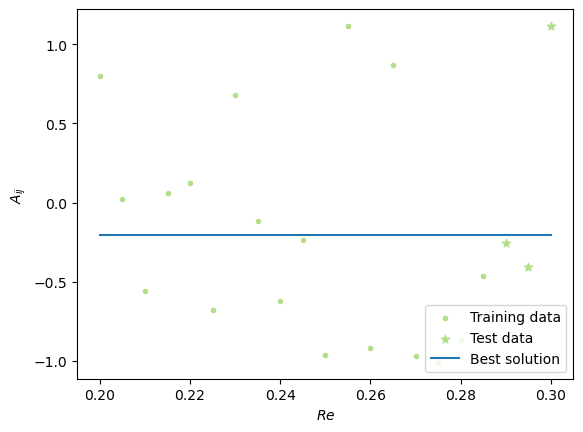

In [139]:
plt.scatter(train_val_data_i_j.X/1000, train_val_data_i_j.y,
                c="#b2df8a", marker=".", label="Training data")
plt.scatter(test_data_i_j.X/1000, test_data_i_j.y, c="#b2df8a", marker="*", label="Test data")
plt.plot(k_sample, model_out[:,0].detach().numpy(), c="#1f78b4", label="Best solution")
plt.xlabel(r"$Re$")
plt.ylabel(r"$A_{ij}$")
plt.legend(loc="lower right")
plt.show()